# Introduction 

* This code is adapted from the example provided in the python optimal transport package (POT)

This notebook presents the results of mapping a 2D uniform input distribution to a 2D uniform target distribution. 



## Imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl
import matplotlib.animation as animation
import torch
from torch import nn
import ot

import scipy
import random
# import sys
# !{sys.executable} -m pip install pot

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

seed = 126
torch.manual_seed(seed) # make chunk execution consistent 


__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 4080
__CUDA Device Total Memory [GB]: 16.860184576


## Data generation

In [2]:
torch.manual_seed(seed) # make chunk execution consistent 

sigma = 0.0
n_dims = 2
n_features = 3

def get_data(n_samples):
    # c = torch.rand(size=(n_samples, 2))
    c1 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c2 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c = torch.cartesian_prod(c1,c2)
    x = c
    return x

def get_data_normal(n_samples):
    c = torch.randn(n_samples**2, 2) # match previous
    # c = 1/(1+torch.exp(-0.5*c))
    x = c
    return x

def get_data_sobol(n_samples):
    a = scipy.stats.qmc.Sobol(d=2, scramble=True, optimization='lloyd')
    c = torch.tensor(a.random_base2(m=n_samples)).float()
    return c


# empirical fill-based loss  
from scipy.spatial.distance import cdist
def fill_distance(data, fitted, type='max'): 
    m = torch.tensor(cdist(data, fitted, 'euclidean')) 
    # m = cdist(data, fitted, 'euclidean')
    min, min_indices = torch.min(m, dim=1) # min across rows 
    if type=='max':
        fill_dist = max(min)
    elif type=='mean':
        fill_dist = torch.mean(min)
    else:
        fill_dist = max(min)

    return fill_dist.item() # get actual float 

## Plot data



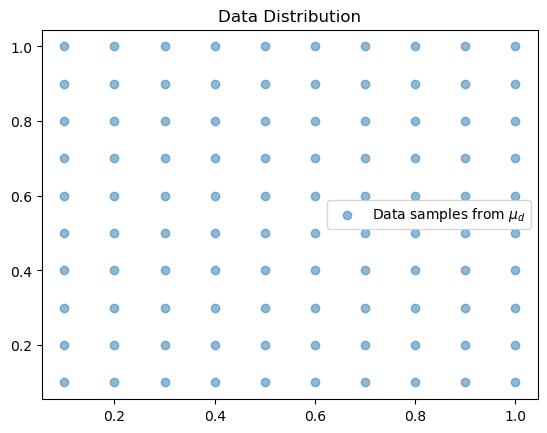

In [3]:
torch.manual_seed(seed) # make chunk execution consistent 

# plot the distributions
x = get_data(10)
pl.figure(1)
pl.scatter(x[:, 0], x[:, 1], label='Data samples from $\mu_d$', alpha=0.5)
pl.title('Data Distribution')
pl.legend()


## Generator Model



In [64]:
torch.manual_seed(seed) # make chunk execution consistent 

class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 3
        self.n_out = 2
        n= 200
        leaky = 0.0001
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, self.n_out),
        )
    def forward(self, x):
        x = self.model(x)
        return x
    
class Generator2(torch.nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.n_features = 3
        self.n_out = 2
        n= 10
        leaky = 0.0001
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, n),
            nn.LeakyReLU(leaky),
           #  nn.Linear(n, n),
           #  nn.LeakyReLU(leaky),
            nn.Linear(n, self.n_out),
        )
    def forward(self, x):
        x = self.model(x)
        return x
    
g1 = Generator()
g2 = Generator2()
num_hidden_layers = sum(1 for _ in g1.modules() if isinstance(_, nn.Linear))
print(f"The number of hidden layers in G1 is: {num_hidden_layers}")
num_hidden_layers = sum(1 for _ in g2.modules() if isinstance(_, nn.Linear))
print(f"The number of hidden layers in G2 is: {num_hidden_layers}")


The number of hidden layers in G1 is: 6
The number of hidden layers in G2 is: 2


## Training the model



Iter: 0, 	 wass-loss=0.26797, 	 fill-dist=0.39002
Iter: 10, 	 wass-loss=0.20892, 	 fill-dist=0.33605
Iter: 20, 	 wass-loss=0.17659, 	 fill-dist=0.3066
Iter: 30, 	 wass-loss=0.15531, 	 fill-dist=0.2803
Iter: 40, 	 wass-loss=0.13791, 	 fill-dist=0.26379
Iter: 50, 	 wass-loss=0.12444, 	 fill-dist=0.24415
Iter: 60, 	 wass-loss=0.11204, 	 fill-dist=0.22899
Iter: 70, 	 wass-loss=0.1032, 	 fill-dist=0.21703
Iter: 80, 	 wass-loss=0.09536, 	 fill-dist=0.20668
Iter: 90, 	 wass-loss=0.08597, 	 fill-dist=0.19596
Iter: 100, 	 wass-loss=0.08, 	 fill-dist=0.18419
Iter: 110, 	 wass-loss=0.07674, 	 fill-dist=0.17935
Iter: 120, 	 wass-loss=0.07163, 	 fill-dist=0.16764
Iter: 130, 	 wass-loss=0.0691, 	 fill-dist=0.16472
Iter: 140, 	 wass-loss=0.06635, 	 fill-dist=0.1574
Iter: 150, 	 wass-loss=0.06317, 	 fill-dist=0.15179
Iter: 160, 	 wass-loss=0.06193, 	 fill-dist=0.15228
Iter: 170, 	 wass-loss=0.06145, 	 fill-dist=0.14361
Iter: 180, 	 wass-loss=0.06267, 	 fill-dist=0.14428
Iter: 190, 	 wass-loss=0.05982,

Text(0.5, 0, 'Iterations')

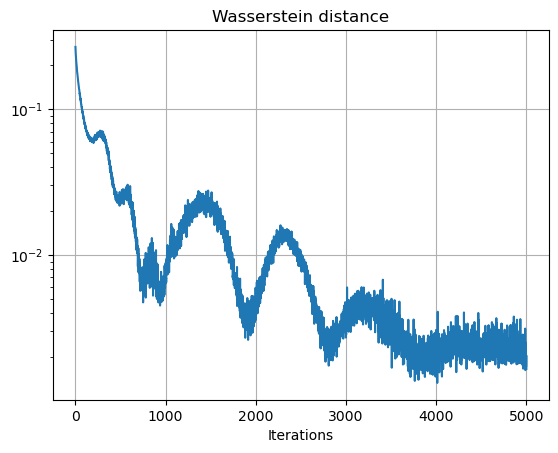

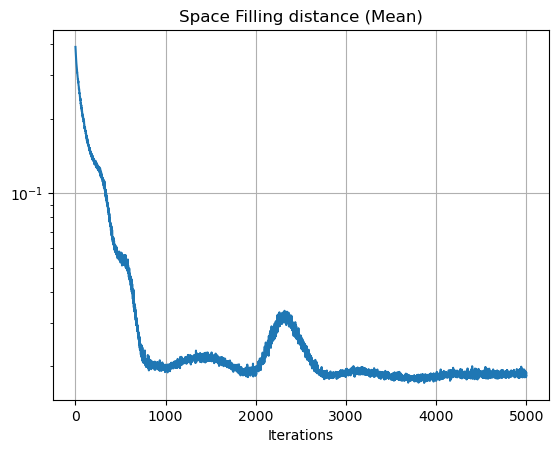

In [66]:
torch.manual_seed(seed) # make chunk execution consistent 

G = Generator2()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-6)
# optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5, weight_decay=1e-15)

# number of iteration and size of the batches
n_iter = 5000
size_batch = 30 # need to square this to facilitate cartesian product in get_data()

# generate static samples to see their trajectory along training
n_visu = size_batch**2

################################################################################
# grid input for visualization
c_size = 10
c1 = torch.arange(1, c_size+1) / (c_size)# .reshape((n_samples, 1)) / (n_samples)
c2 = torch.arange(1, c_size+1) / (c_size)# .reshape((n_samples, 1)) / (n_samples)
c3 = torch.arange(1, c_size+1) / (c_size)# .reshape((n_samples, 1)) / (n_samples)
c = torch.cartesian_prod(c1,c2, c3)
xnvisu = c
# xnvisu = torch.rand(size_batch**2, n_features)


# Define the total number of points
num_points = size_batch**2

# Find the closest integer cube root
points_per_dim = int(round(num_points ** (1/3)))

# Generate linearly spaced points in each dimension
x = np.linspace(0, 1, points_per_dim)
y = np.linspace(0, 1, points_per_dim)
z = np.linspace(0, 1, points_per_dim)

# Create a 3D grid using meshgrid and reshape into a uniform point cloud
grid_x, grid_y, grid_z = np.meshgrid(x, y, z)
grid = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()]).T

# Trim the grid randomly to exactly 1000 points (if needed)
random_indices = np.random.choice(grid.shape[0], num_points, replace=False)
random_grid = grid[random_indices]
xnvisu = torch.tensor(random_grid, dtype=torch.float32)
################################################################################


xvisu = torch.zeros(n_iter, size_batch**2, n_dims)
ab = torch.ones(size_batch**2) / size_batch**2
losses = []
fill_losses = []

# train mode
G.train()

# generate data samples
xd = get_data(size_batch) # 27^2 = 729 = 9^3

for i in range(n_iter):

    # generate noise samples
    xn = torch.rand(size_batch**2, n_features) # random sample every iteration 
    # xn = get_data(size_batch) # for uniform grid

    # generate data samples
    # xd = get_data_normal(size_batch)

    # generate sample along iterations
    G.eval()
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate samples and compute distance matrix
    G.train()
    xg = G(xn)

    M = ot.dist(xg, xd)
    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))
    # print(losses)

    fill_loss = fill_distance(xd.detach().numpy(), xg.detach().numpy(), type='mean')
    fill_losses.append(fill_loss)

    if i % 10 == 0:
        # print("Iter: {:3d}, loss={}".format(i, losses[-1]))
        print(f"Iter: {i}, \t wass-loss={round(losses[-1], 5)}, \t fill-dist={round(fill_loss, 5)}")

    loss.backward()
    optimizer.step()

    del M

# wasserstein loss 
pl.figure(2)
pl.semilogy(losses)
pl.grid()
pl.title('Wasserstein distance')
pl.xlabel("Iterations")

# fill distance 
pl.figure(3)
pl.semilogy(fill_losses)
pl.grid()
pl.title('Space Filling distance (Mean)')
pl.xlabel("Iterations")

## Plot trajectories of generated samples along iterations



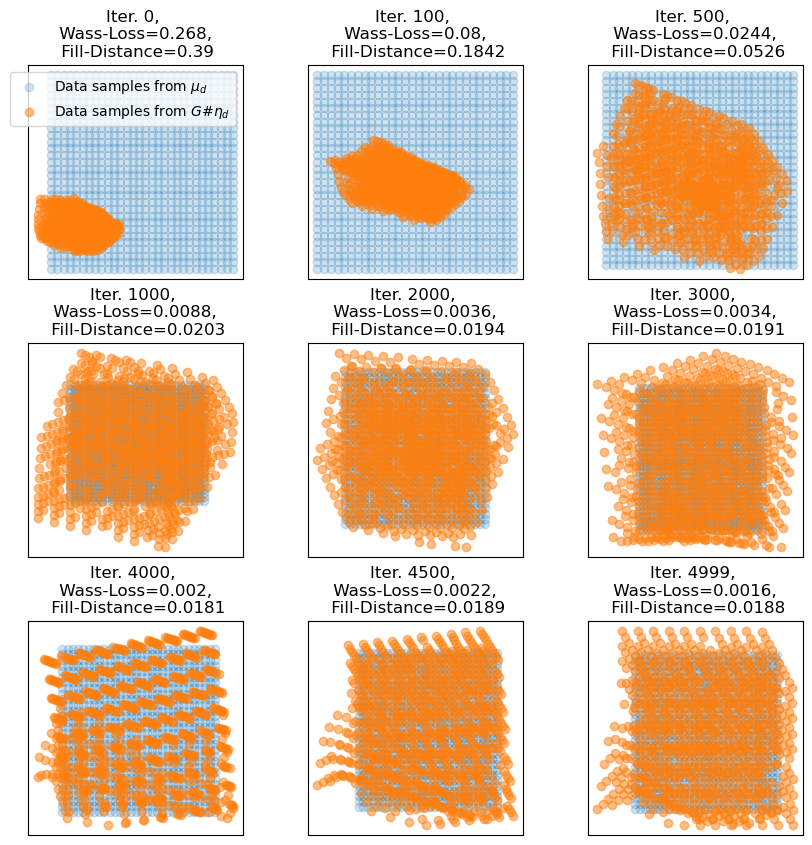

In [68]:
torch.manual_seed(seed) # make chunk execution consistent 

# ivisu = [0, 50, 100, 500, n_iter-3000, n_iter-2000, n_iter-1000, n_iter-500, n_iter-1]
ivisu = [0, 100, 500, 1000, 2000, 3000, 4000, 4500, n_iter-1]

# ivisu = [0, 50, 100, 200, 500, n_iter-300, n_iter-200, n_iter-100, n_iter-1]
# ivisu = [0, 1000, 2500, 5000, n_iter-5000, n_iter-3000, n_iter-2000, n_iter-1000, n_iter-1]


pl.figure(3, (10, 10))

for i in range(9):
    
    pl.subplot(3, 3, i + 1)

    # use the distances to map to colors
    progression = np.linspace(0, 1, n_visu)  # Normalize progression to [0, 1], not used here 
    
    pl.scatter(xd[:, 0], xd[:, 1], label='Data samples from $\mu_d$', alpha=0.2)
    pl.scatter(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], 
               label='Data samples from $G\#\eta_d$', 
               alpha=.5,
                #c = progression,
                #cmap='Oranges'
                )

    pl.xticks(())
    pl.yticks(())
    pl.title(f'Iter. {ivisu[i]}, \n Wass-Loss={round(losses[ivisu[i]], 4)}, \n Fill-Distance={round(fill_losses[ivisu[i]], 4)}')
    if i == 0:
        pl.legend()
    
# adjust the spacing
pl.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

